In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.transforms as transforms

plt.style.use('seaborn-paper')
plt.style.use(['default', 'bmh', 'seaborn-paper'])

%matplotlib inline

In [2]:
def calculate(data, labels, metrics, operation):
    means = dict()
    for metric in metrics:
        values = [operation(data[label][metric]) for label in labels]
        means[metric] = values
    return means 

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]

def plot_accuracy(data, gt, labels, title='Accuracy'):
    plt.title(title, fontsize=20)
    
    # Data
    x = np.arange(len(data)) + 1
    y = data
    plt.bar(x, y)
    
    # GT
    plt.hlines(gt, x[0]-1, x[-1]+1, linestyles= 'dashed')
    plt.text(x[0]-2, gt, f"{int(gt)}", ha="right", va="center")
    plt.text(x[-1]+1, gt, "GT", ha="right", va="bottom") 
    
    # Bar limits
    min_value = min(min(data), gt) - 10
    max_value = max(max(data), gt) + 10
    plt.ylim(bottom=min_value, top=max_value)
    
    plt.xlabel('Filters applied (Decimation, Disparity, Spatial and Temporal)', fontsize=14)
    plt.xticks(x, labels, fontsize=10, rotation=45)
    plt.ylabel('distance (mm)', fontsize=14)
    
def plot_data(data, labels, title):
    plt.title(title, fontsize=20)
    
    x = np.arange(len(data)) + 1
    y = data
    plt.bar(x, y)
    
    plt.xlabel('Filters applied (Decimation, Disparity, Spatial and Temporal)', fontsize=14)
    plt.xticks(x, labels, fontsize=10, rotation=45)


def plot_profit_data(data, labels, title, more_is_better=True):
    base = data[0]
    
    if more_is_better:
        profit = [((value - base) / value) * 100 for value in data]
    else:
        profit = [((base - value) / value) * 100 for value in data]

    plt.title(title, fontsize=20)

    x = np.arange(len(data)) + 1
    y = profit
    plt.bar(x, y)
    
    plt.hlines(0, x[0]-.5, x[-1]+.5, label="base")
    # plot values: base, max, min in right axis
    plt.text(x[-1]+1.5, 0, f"{base:.5} %", ha="left", va="center")
    plt.text(x[-1]+1.5, np.min(profit), f"{data[np.argmin(profit)]:.5} %", ha="left", va="center")
    plt.text(x[-1]+1.5, np.max(profit), f"{data[np.argmax(profit)]:.5} %", ha="left", va="center")
    
    plt.xlabel('Filters applied (Decimation, Disparity, Spatial and Temporal)', fontsize=14)
    plt.ylabel('percentage of improvement', fontsize=14)
    plt.xticks(x, labels, fontsize=10, rotation=45)
    




### Read data

Order of filters: decimation, disparity, spatial and temporal. <br>
T: Activated <br>
F: Deactivated <br>

https://www.intel.com/content/dam/support/us/en/documents/emerging-technologies/intel-realsense-technology/RealSense_DepthQualityTesting.pdf

In [4]:
path = './rs-depth-quality_data/260'  # 30, 70, 260
ext = '_depth_metrics.csv'
labels = [''.join(it) for it in itertools.product('FT', repeat=4)]

In [5]:
raw_data = dict()
filenames = [os.path.join(path, name + ext) for name in labels]
for label, filename in zip(labels, filenames):
    if not os.path.exists(filename):
        raise OSError('File "{}" not found'.format(filename))
    
    content = np.genfromtxt(filename, delimiter=',', skip_header=16, 
                            names=['samples_ID', 'frame', 'timestamp', 'fill_rate', 'Z_Accuracy','RMS_Error', 'RMS_Error_pixel', 'distance'],
                            dtype=['i', 'i8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8']) 

    raw_data[label] = content
    raw_data[label]['distance'] = float(np.genfromtxt(filename, delimiter=',', usecols=(1), max_rows=1, skip_header=12))
    
gt_distance = float(np.genfromtxt(filenames[0], delimiter=',', usecols=(1), max_rows=1, skip_header=13))
gt_distance

2575.0

### Extract measures


In [6]:
measures = ['fill_rate', 'Z_Accuracy','RMS_Error', 'RMS_Error_pixel']
means = calculate(raw_data, labels, measures, np.mean)    
stds  = calculate(raw_data, labels, measures, np.std)   

distances = [raw_data[label]['distance'][0] for label in labels]

# PLOT DATA

Showing the data as the profits/losses with respect to the data obtained without applying any filter (FFFF).

----
## Fill rate

Fill rate measures the portion (e.g., %) of the depth image containing valid pixels (pixels with non-zero depth values). This metric is independent of the accuracy of the depth data or its noise

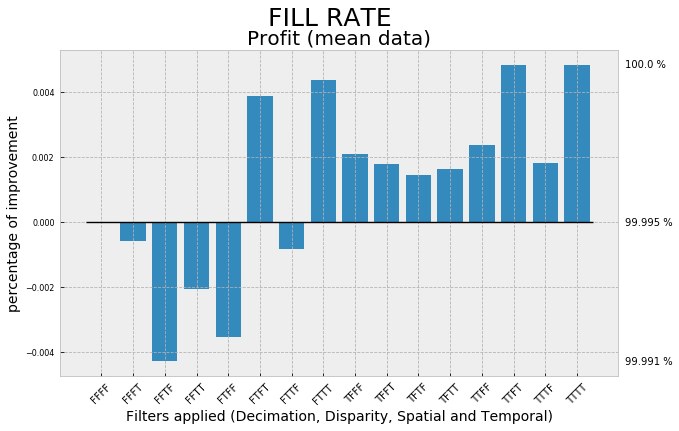

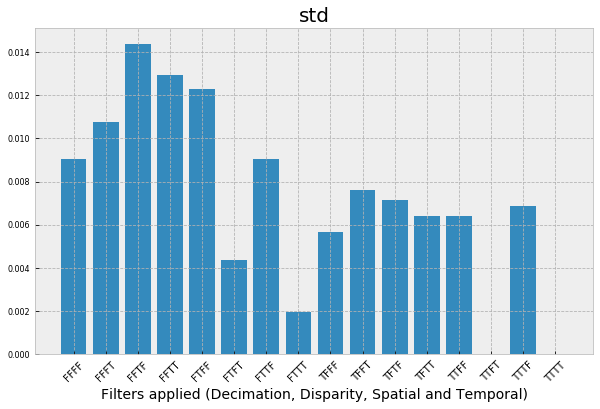

In [7]:
plt.suptitle('FILL RATE', fontsize=25)
plot_profit_data(means['fill_rate'], labels, 'Profit (mean data)') 
plt.show()
plot_data(stds['fill_rate'], labels, 'std')       
plt.show()

----
## Z-accuracy
Z-accuracy(or absolute error): Measures how close the reported depth values are to the actual distance (ground truth, GT). Z accuracy may be defined in a variety of ways but most definitions use differences (which may be signed or magnitude) between measured depth values (per pixel or averaged over an ROI) and GT. In most cases, a flat surface (target) aligned parallel to the depth camera is used in order to simplify the measurement since GT may be accurately estimated from a single measurement using an independent absolute measuring device such as laser rangefinder or tape measure.

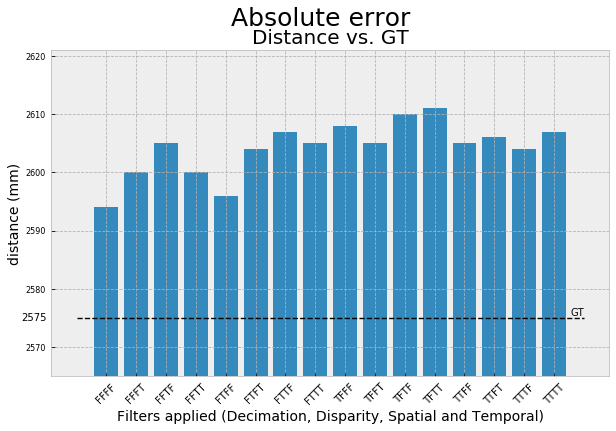

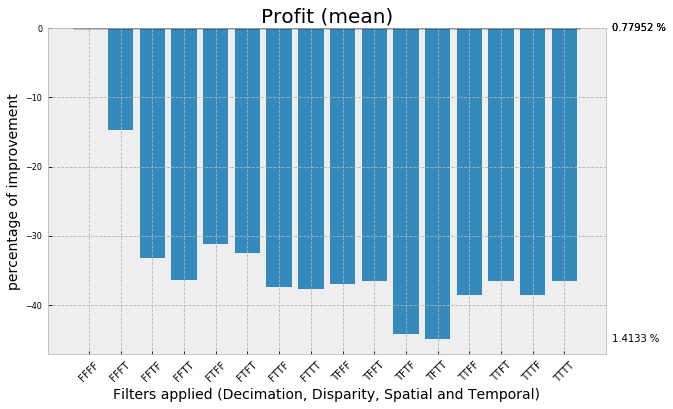

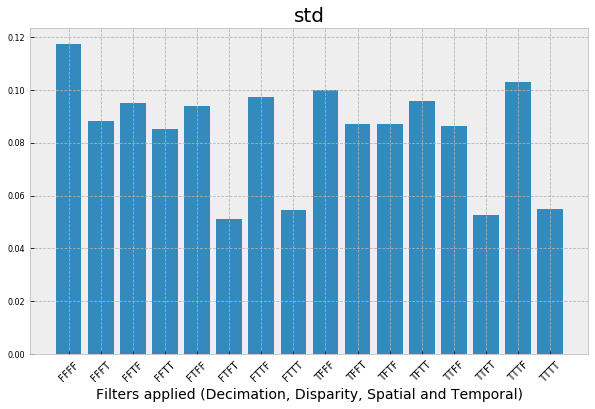

In [8]:
plt.suptitle('Absolute error', fontsize=25)
plot_accuracy(distances, gt_distance, labels, 'Distance vs. GT')
plt.show()
plot_profit_data(means['Z_Accuracy'], labels, 'Profit (mean)', more_is_better=False) 
plt.show()
plot_data(stds['Z_Accuracy'], labels, 'std')       
plt.show()

---
## Spatial Noise

RMS Error (or Spatial Noise) measures the intrinsic variation in depth values across an ROI assuming a planar target. This metric is independent of the accuracy of the depth values or fill rate since invalid pixels are not included.  A flat target is used to measure the spatial noise and it is typically defined as an RMS deviation of depth values from the best-fit plane to the data. Plane fitting of the data aids in reducing the sensitivity of the measurement to alignment errors between the camera and the target. A related measure of spatial noise is a standard deviation (STD) of the directly measured depth values. While STD can also providea measure of spatial noise,any variation in depth across the ROI due to misalignment will bias the result and lead to a larger spatial noise value than is intrinsic to the camera. Spatial noise may be quantifiedin either distance (e.g., mm)ordisparity (e.g., pixels)units. Spatial noise in pixels(thefundamental depth camera unit), referred to as ‘subpixel RMS error’, has the advantage of being virtually independent of distance to the target, whereas noise measured in distance units is depth dependent but more commonly understood and relevant for most camera usages. For these reasons, both are typically used to evaluatecamera performance.

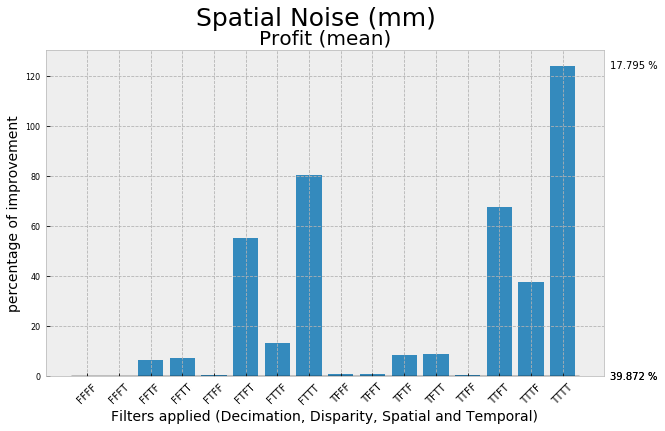

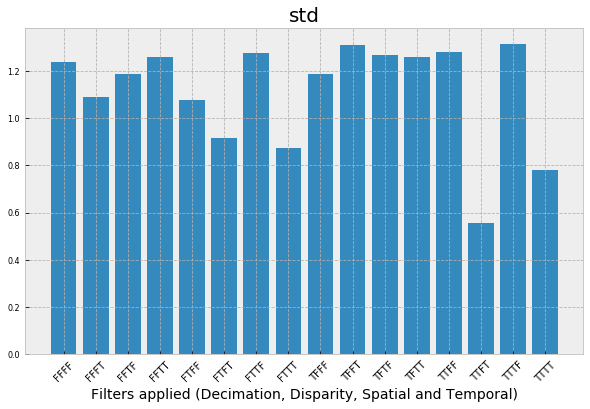

In [9]:
plt.suptitle('Spatial Noise (mm)', fontsize=25)
plot_profit_data(means['RMS_Error'], labels, 'Profit (mean)', more_is_better=False) 
plt.show()
plot_data(stds['RMS_Error'], labels, 'std')       
plt.show()

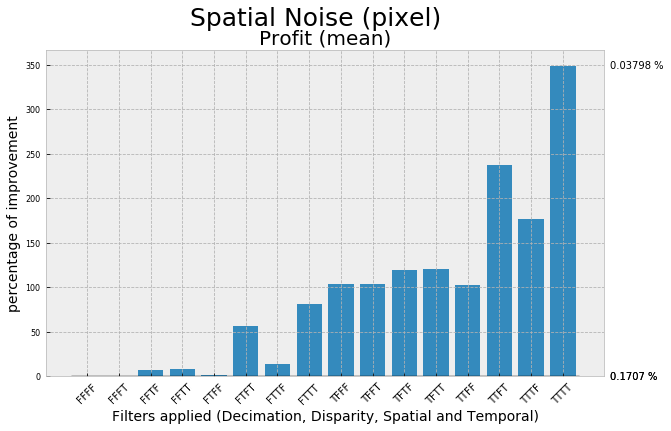

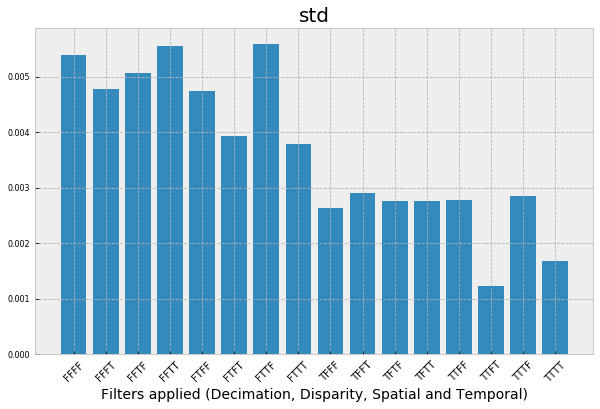

In [10]:
plt.suptitle('Spatial Noise (pixel)', fontsize=25)
plot_profit_data(means['RMS_Error_pixel'], labels, 'Profit (mean)', more_is_better=False) 
plt.show()
plot_data(stds['RMS_Error_pixel'], labels, 'std')       
plt.show()